In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

from torch.distributions.multivariate_normal import MultivariateNormal


import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics, Entropy

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [3]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.Tanh()

#generative model
lat_dim=5



#optimizer
learning_rate=0.01

#scheduler
patience=30
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=1000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=10 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")
device

device(type='cuda', index=0)

# Setup #

255.44154571533204 6.812229936353754


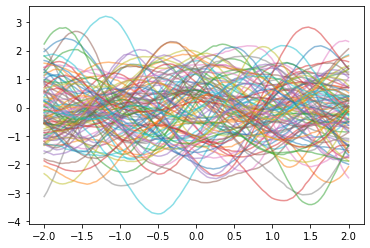

In [5]:
class GaussianProcess(nn.Module):
    def __init__(self, mean, lengthscale, noise=0.05):
        super(GaussianProcess, self).__init__()
        self.ls=lengthscale
        self.mean=mean
        self.var=noise**2

    def covar_matrix(self,x):
        K=torch.cdist(x.div(self.ls),x.div(self.ls),p=2).pow_(2).div_(-2).exp_()
        return K+self.var*torch.eye(x.shape[0], device=x.device)##
    
    def log_prob(self,inputs,f):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0], device=inputs.device),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.log_prob(f)
    def forward(self, inputs, n=1):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0], device=inputs.device),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.sample((n,)).squeeze()
    
prior=GaussianProcess(mean=torch.tensor(0.),lengthscale=.5, noise=0.01)    
inputs=torch.linspace(-2,2.,100).unsqueeze(-1).to(device)
LPs=[]

for _ in range(100):
    f=prior(inputs).cpu()
    plt.plot(inputs.cpu(),f.cpu(),alpha=0.5)
    LPs.append(prior.log_prob(inputs.cpu(),f).item())
print(np.mean(LPs),np.std(LPs))   

In [6]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='foong_sparse' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=setup.sigma_noise
print(sigma_noise)
sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
#batch_size
batch_size=30


n_samples_FU=10 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=0 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

0.1


# Predictive model #

In [9]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

print('input dim: '+str(input_dim))
print('param count: '+str(param_count))

input dim: 1
param count: 151


In [13]:
#average log likelihood loss
def nll(x_data, y_data, theta, sigma_noise):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of negative loglikelihood
    """

    y_pred=model(x_data,theta)
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise).sum(1)
    return -log_proba.mean()



log_sigma=torch.tensor(0., device=device).requires_grad_(True)
theta=torch.randn((1,param_count), device=device).requires_grad_(True)
params=[theta,log_sigma]
optimizer = torch.optim.Adam(params, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=lr_decay, verbose=True, min_lr=min_lr)

LLs=[]
test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'WAIC':[]
             }
n_epochs=5000

start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        optimizer.zero_grad()
        
        y_pred=model(x_test,theta.detach()).cpu()
        metrics=evaluate_metrics(y_pred, torch.log(1+log_sigma.exp()).detach().cpu().view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        example_count=0.
        
        LL_sum=0.
        example_count=0
        
        with torch.enable_grad():
            for (x,y) in train_loader:
                
                optimizer.zero_grad()

                L=nll(x,y,theta,torch.log(1+log_sigma.exp()))
                                
                L.backward()
                
                optimizer.step()

                LL_sum+=L.item()*len(x)
                example_count+=len(x)
            epoch_LL=LL_sum/example_count
            scheduler.step(epoch_LL)
            LLs.append(epoch_LL)
            tr.set_postfix(LogLike=-epoch_LL, sigma=log_sigma.exp().item())

        if optimizer.param_groups[0]['lr'] <= 1e-4:
            break
   


100%|██████████| 5000/5000 [00:24<00:00, 208.07it/s, LogLike=29.8, sigma=0.0759]  


In [14]:
sigma_noise=log_sigma.exp().clone().detach().to(device)#torch.tensor(0.1,device=device)#
print(sigma_noise.item())

0.07592815905809402


# ELBO

## Average Log Likelihood

In [32]:
from Tools import log_norm
#average log likelihood loss
def loss(x_data, y_data, GeN, std):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    std: tensor of size 1x N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    log_proba=log_norm( y_data.unsqueeze(1), y_pred, std).sum(1)
    return log_proba.mean()

## Kullback-Leibler divergence in Predictor space

In [42]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
#    epsilon=0.1
    M = 2.#x_train.max(0, keepdim=True)[0]+epsilon
    m = -2.#x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj
n_ood=10
def ood_input(n_ood=n_ood):
    M =2.
    m =-2.
    return torch.rand(n_ood,input_dim).to(device) * (M-m) + m  


def kl(GeN):
    theta=GeN(n_samples_KL) #variationnel
    X_ood=ood_input()
    f_theta=model(X_ood, theta).squeeze(2)
    f_prior=prior(X_ood,n=n_samples_KL)
    k=KL(f_theta,f_prior,k=kNNE,device=device)
    return k


def kl_(GeN):
    theta=GeN(n_samples_KL) #variationnel
    n_ood=10
    X_ood=ood_input()
    f_theta=model(X_ood, theta).squeeze(2)
    H=Entropy(f_theta,k_MC=n_ood)
    logtarget=prior.log_prob(X_ood,f_theta).mean()
    return -H-logtarget


def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

## ELBO ##

In [43]:
#ELBO

def ELBO(x_data, y_data, GeN, theta_log_sigma):
    alpha=(len(x_data)/size_data)
    log_sigma=model(x_data,theta_log_sigma)
    sigma_noise= torch.log(1. + log_sigma.exp()) + 1e-6
    Average_LogLikelihood=loss(x_data, y_data, GeN, sigma_noise)
    the_KL=kl_(GeN)
    the_ELBO= - Average_LogLikelihood+ alpha*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [56]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=151, bias=True)
  )
)


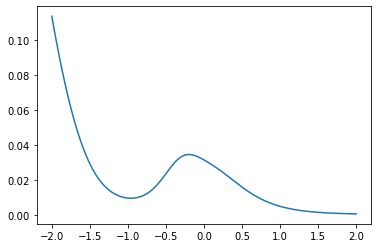

In [57]:
theta_log_sigma=torch.randn((1,param_count),device=device).requires_grad_(True)
x_pred=torch.linspace(-2.,2.,1000).to(device)

log_sigma=model(x_pred,theta_log_sigma)
sigma_noise= torch.log(1. + log_sigma.exp()).detach()#torch.log(1. + log_sigma.exp()).detach() + 1e-6
plt.plot(x_pred.cpu(),sigma_noise.squeeze().cpu())

# Optimizer

In [58]:
class IVI():
    def __init__(self, train_loader, ELBO,
                 optimizer):
        
        self.train_loader=train_loader
        self.ELBO=ELBO
        
        self.optimizer=optimizer



    def run(self, GeN):

        self.scores={'ELBO':0. ,
                     'KL':0.,
                     'LL':0.
        }
        example_count=0.
        
        GeN.train(True)
        with torch.enable_grad():
            for (x,y) in self.train_loader:

                self.optimizer.zero_grad()
                
                
                L, K, LL=self.ELBO(x,y,GeN, theta_log_sigma)
                L.backward()

                lr = self.optimizer.param_groups[0]['lr']

                self.optimizer.step()

                self.scores['ELBO']+= L.item()*len(x)
                self.scores['KL']+= K.item()*len(x)
                self.scores['LL']+=LL.item()*len(x)
                example_count+=len(x)
    
        mean_scores={'ELBO': self.scores['ELBO']/example_count ,
             'KL':self.scores['KL']/example_count,
             'LL':self.scores['LL']/example_count,
             'lr':lr
            }
        return mean_scores

In [59]:
optimizer = torch.optim.Adam([{'params':GeN.parameters()},
                              {'params':[theta_log_sigma], 'lr':5e-2}], lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [60]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [61]:
KLs=[]
ELBOs=[]
LLs=[]
LRs=[]

test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'WAIC':[],
              'KL_train':[],
              'HMC_OOD':[],
              'HMC_train':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        theta=GeN(1000).detach()
        log_sigma=model(x_test,theta_log_sigma)
        sigma_noise= torch.log(1. + log_sigma.exp()) + 1e-6
        y_pred=model(x_test,theta)
        metrics=evaluate_metrics(y_pred, sigma_noise.view(1,-1,1).cpu(), y_test,  std_y_train, device='cpu', std=False)
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN)
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



 45%|████▍     | 447/1000 [00:43<00:52, 10.48it/s, ELBO=102, KL=23.3, LogLike=-78.4, lr=0.005]    

Epoch   445: reducing learning rate of group 0 to 5.0000e-03.
Epoch   445: reducing learning rate of group 1 to 2.5000e-02.


 57%|█████▊    | 575/1000 [00:56<00:46,  9.23it/s, ELBO=99.4, KL=21.4, LogLike=-78, lr=0.0025]  

Epoch   574: reducing learning rate of group 0 to 2.5000e-03.
Epoch   574: reducing learning rate of group 1 to 1.2500e-02.


 82%|████████▏ | 821/1000 [01:20<00:17, 10.50it/s, ELBO=87.5, KL=9.93, LogLike=-77.5, lr=0.00125]

Epoch   819: reducing learning rate of group 0 to 1.2500e-03.
Epoch   819: reducing learning rate of group 1 to 6.2500e-03.


100%|█████████▉| 996/1000 [01:37<00:00, 10.43it/s, ELBO=88.1, KL=10.4, LogLike=-77.7, lr=0.000625]

Epoch   996: reducing learning rate of group 0 to 6.2500e-04.
Epoch   996: reducing learning rate of group 1 to 3.1250e-03.


100%|██████████| 1000/1000 [01:37<00:00, 10.26it/s, ELBO=87.7, KL=10.4, LogLike=-77.3, lr=0.000625]


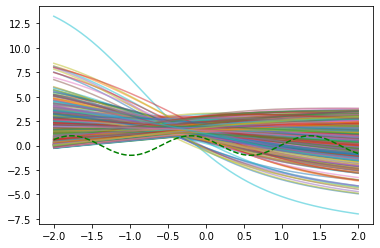

In [62]:
inputs=torch.linspace(-2.,2.,500).unsqueeze(-1).to(device)
for _ in range(1000):
    f=model(inputs,GeN(1)).squeeze().detach().cpu()
    plt.plot(inputs.cpu(),model(inputs,GeN(1)).squeeze().detach().cpu(),alpha=0.5)
plt.plot(inputs.cpu(), torch.cos(4.0*(inputs+0.2)).cpu(),'--',color='green')


torch.Size([1, 1000, 1])


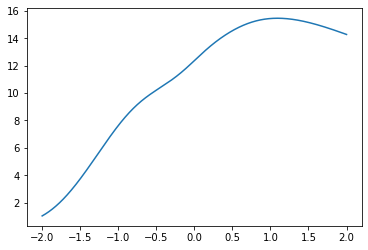

In [63]:
x_pred=torch.linspace(-2.,2.,1000).to(device)

log_sigma=model(x_pred,theta_log_sigma)
sigma_noise= torch.log(1. + log_sigma.exp()).detach() + 1e-6
print(sigma_noise.shape)
plt.plot(x_pred.cpu(),sigma_noise.cpu().squeeze())

999


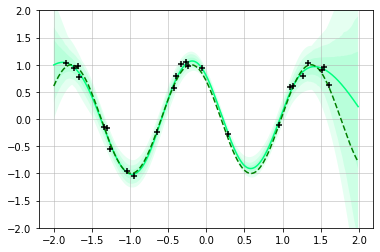

In [27]:
def PlotCI(x_pred, y_pred, x, y, device):
    N=y_pred.shape[0]-1
    print(N)
    m_3=int(0.001*N)
    M_3=N-m_3
    m_2=int(0.021*N)
    M_2=N-m_2
    m_1=int(0.136*N)
    M_1=N-m_1

    x_pred=x_pred.squeeze()

    pred,_=y_pred.sort(dim=0)
    y_mean=y_pred.mean(dim=0).squeeze().cpu()
    y_3=pred[m_3,:].squeeze().cpu()
    Y_3=pred[M_3,:].squeeze().cpu()
    y_2=pred[m_2,:].squeeze().cpu()
    Y_2=pred[M_2,:].squeeze().cpu()    
    y_1=pred[m_1,:].squeeze().cpu()
    Y_1=pred[M_1,:].squeeze().cpu()

    fig, ax=plt.subplots()
    ax.fill_between(x_pred.cpu(), y_3, Y_3, facecolor='springgreen', alpha=0.1)
    ax.fill_between(x_pred.cpu(), y_2, Y_2, facecolor='springgreen', alpha=0.1)
    ax.fill_between(x_pred.cpu(), y_1, Y_1, facecolor='springgreen', alpha=0.1)
    plt.plot(x_pred.cpu(),y_mean, color='springgreen')

    plt.grid(True, which='major', linewidth=0.5)

    plt.ylim(-5, 5)
    plt.scatter(x.cpu(), y.cpu() , marker='+',color='black',zorder=4)
    return fig
%matplotlib inline
theta=GeN(1000).detach()
x_pred=torch.arange(-2.,2.,0.01).to(device)
y_pred=model(x_pred,theta).detach()
log_sigma=model(x_pred,theta_log_sigma)
sigma_noise= torch.log(1. + log_sigma.exp()).detach() + 1e-6
y_pred+=sigma_noise*torch.randn(y_pred.shape[0],1,1).to(device)
fig=PlotCI(x_pred, y_pred, x_train, y_train, device)
ax=fig.get_axes()[0]
ax.set_ylim(-2.,2.)
ax.plot(x_pred.cpu(), torch.cos(4.0*(x_pred.cpu()+0.2)),'--', color='green')

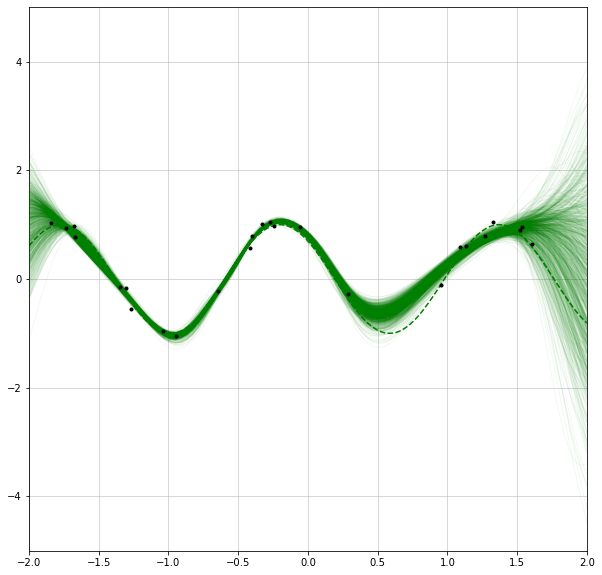

In [441]:
%matplotlib inline
fig=setup.makePlot(GeN(1000).detach(),device)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--', color='green')


# Results on test #

In [66]:
#compute metrics on test

results={}
log_device='cpu'
theta=GeN(2000).detach()
y_pred=model(x_test,theta)
metrics=evaluate_metrics(y_pred, sigma_noise.cpu().view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})

print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

foong_sparse
RMSE: 0.29158592224121094
LPP: 0.2093910276889801
WAIC: -87.0604759156704
PICP: 0.8849999904632568
MPIW: 0.6802104711532593
time [s]: 58.76391024980694


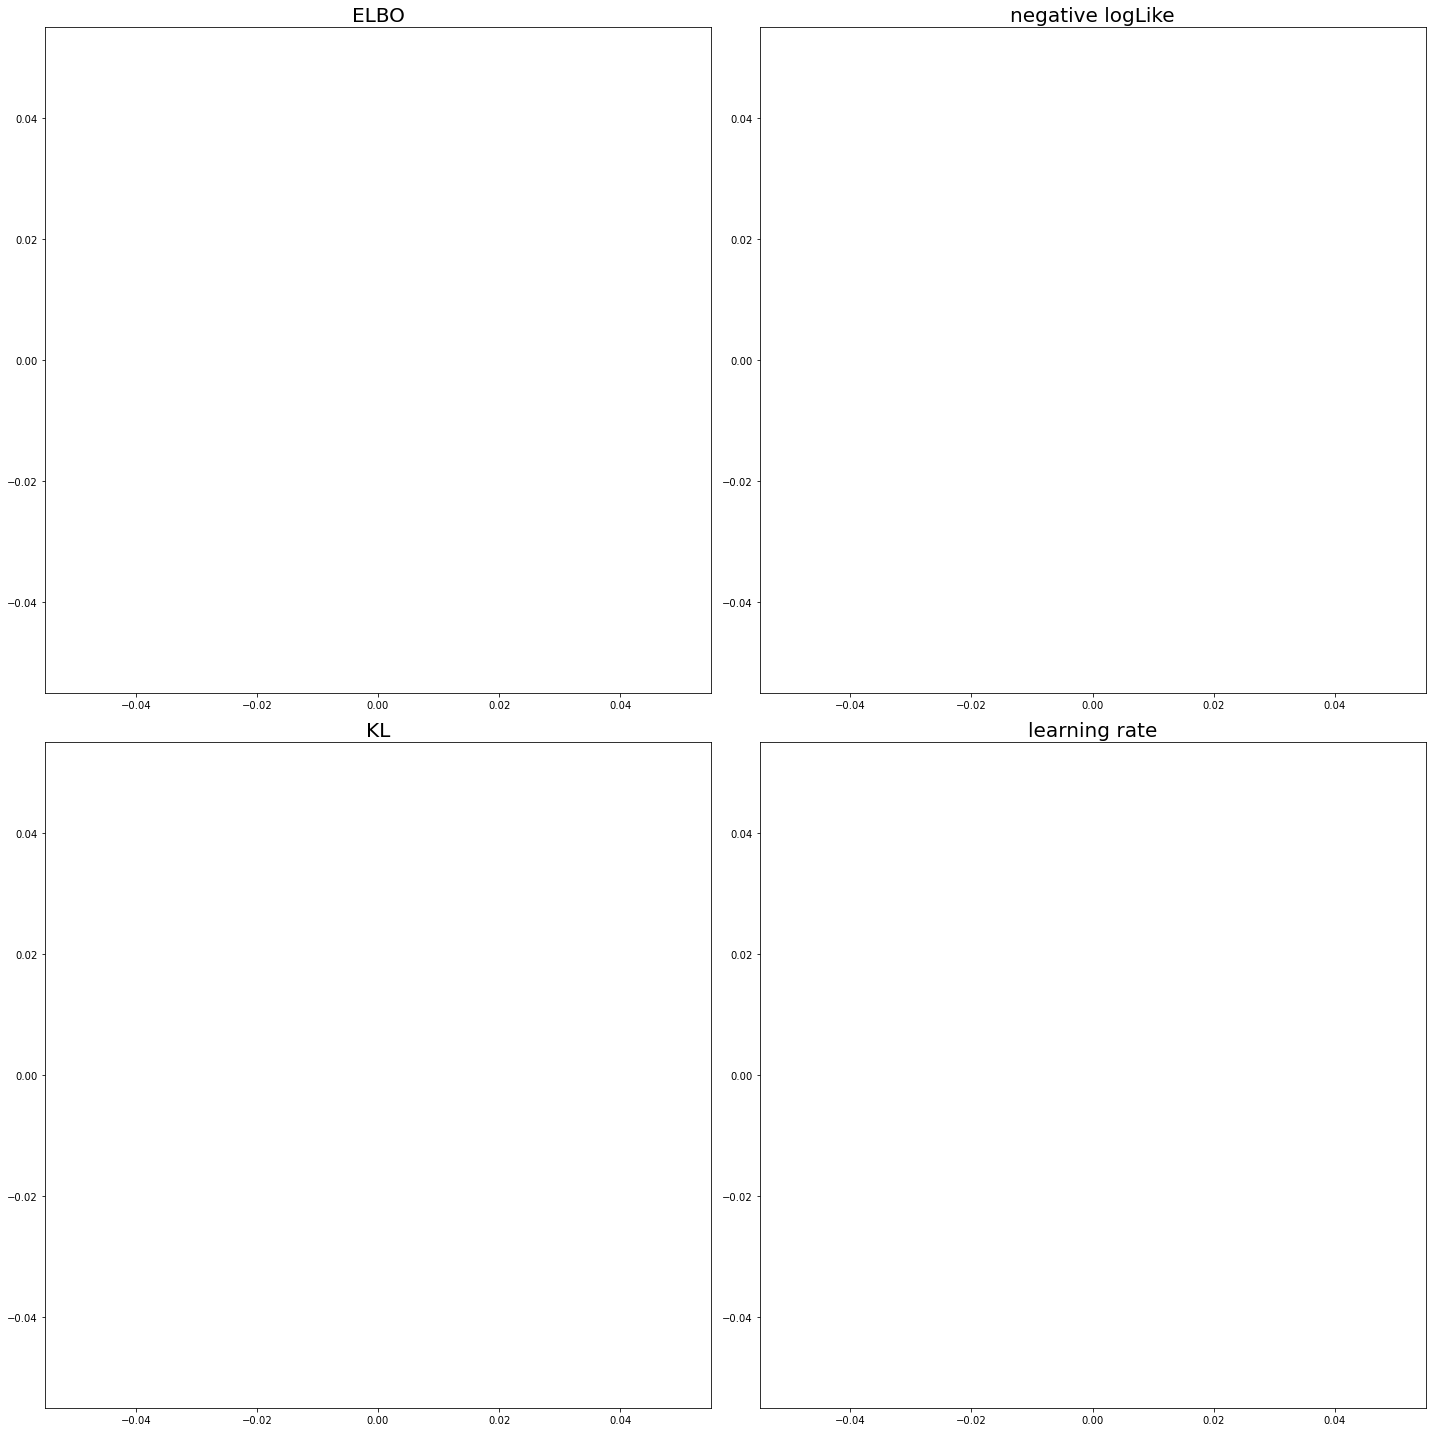

In [443]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LR_=torch.as_tensor(training['LR'])
LL_=torch.as_tensor(training['LL'])

fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
fig.tight_layout()

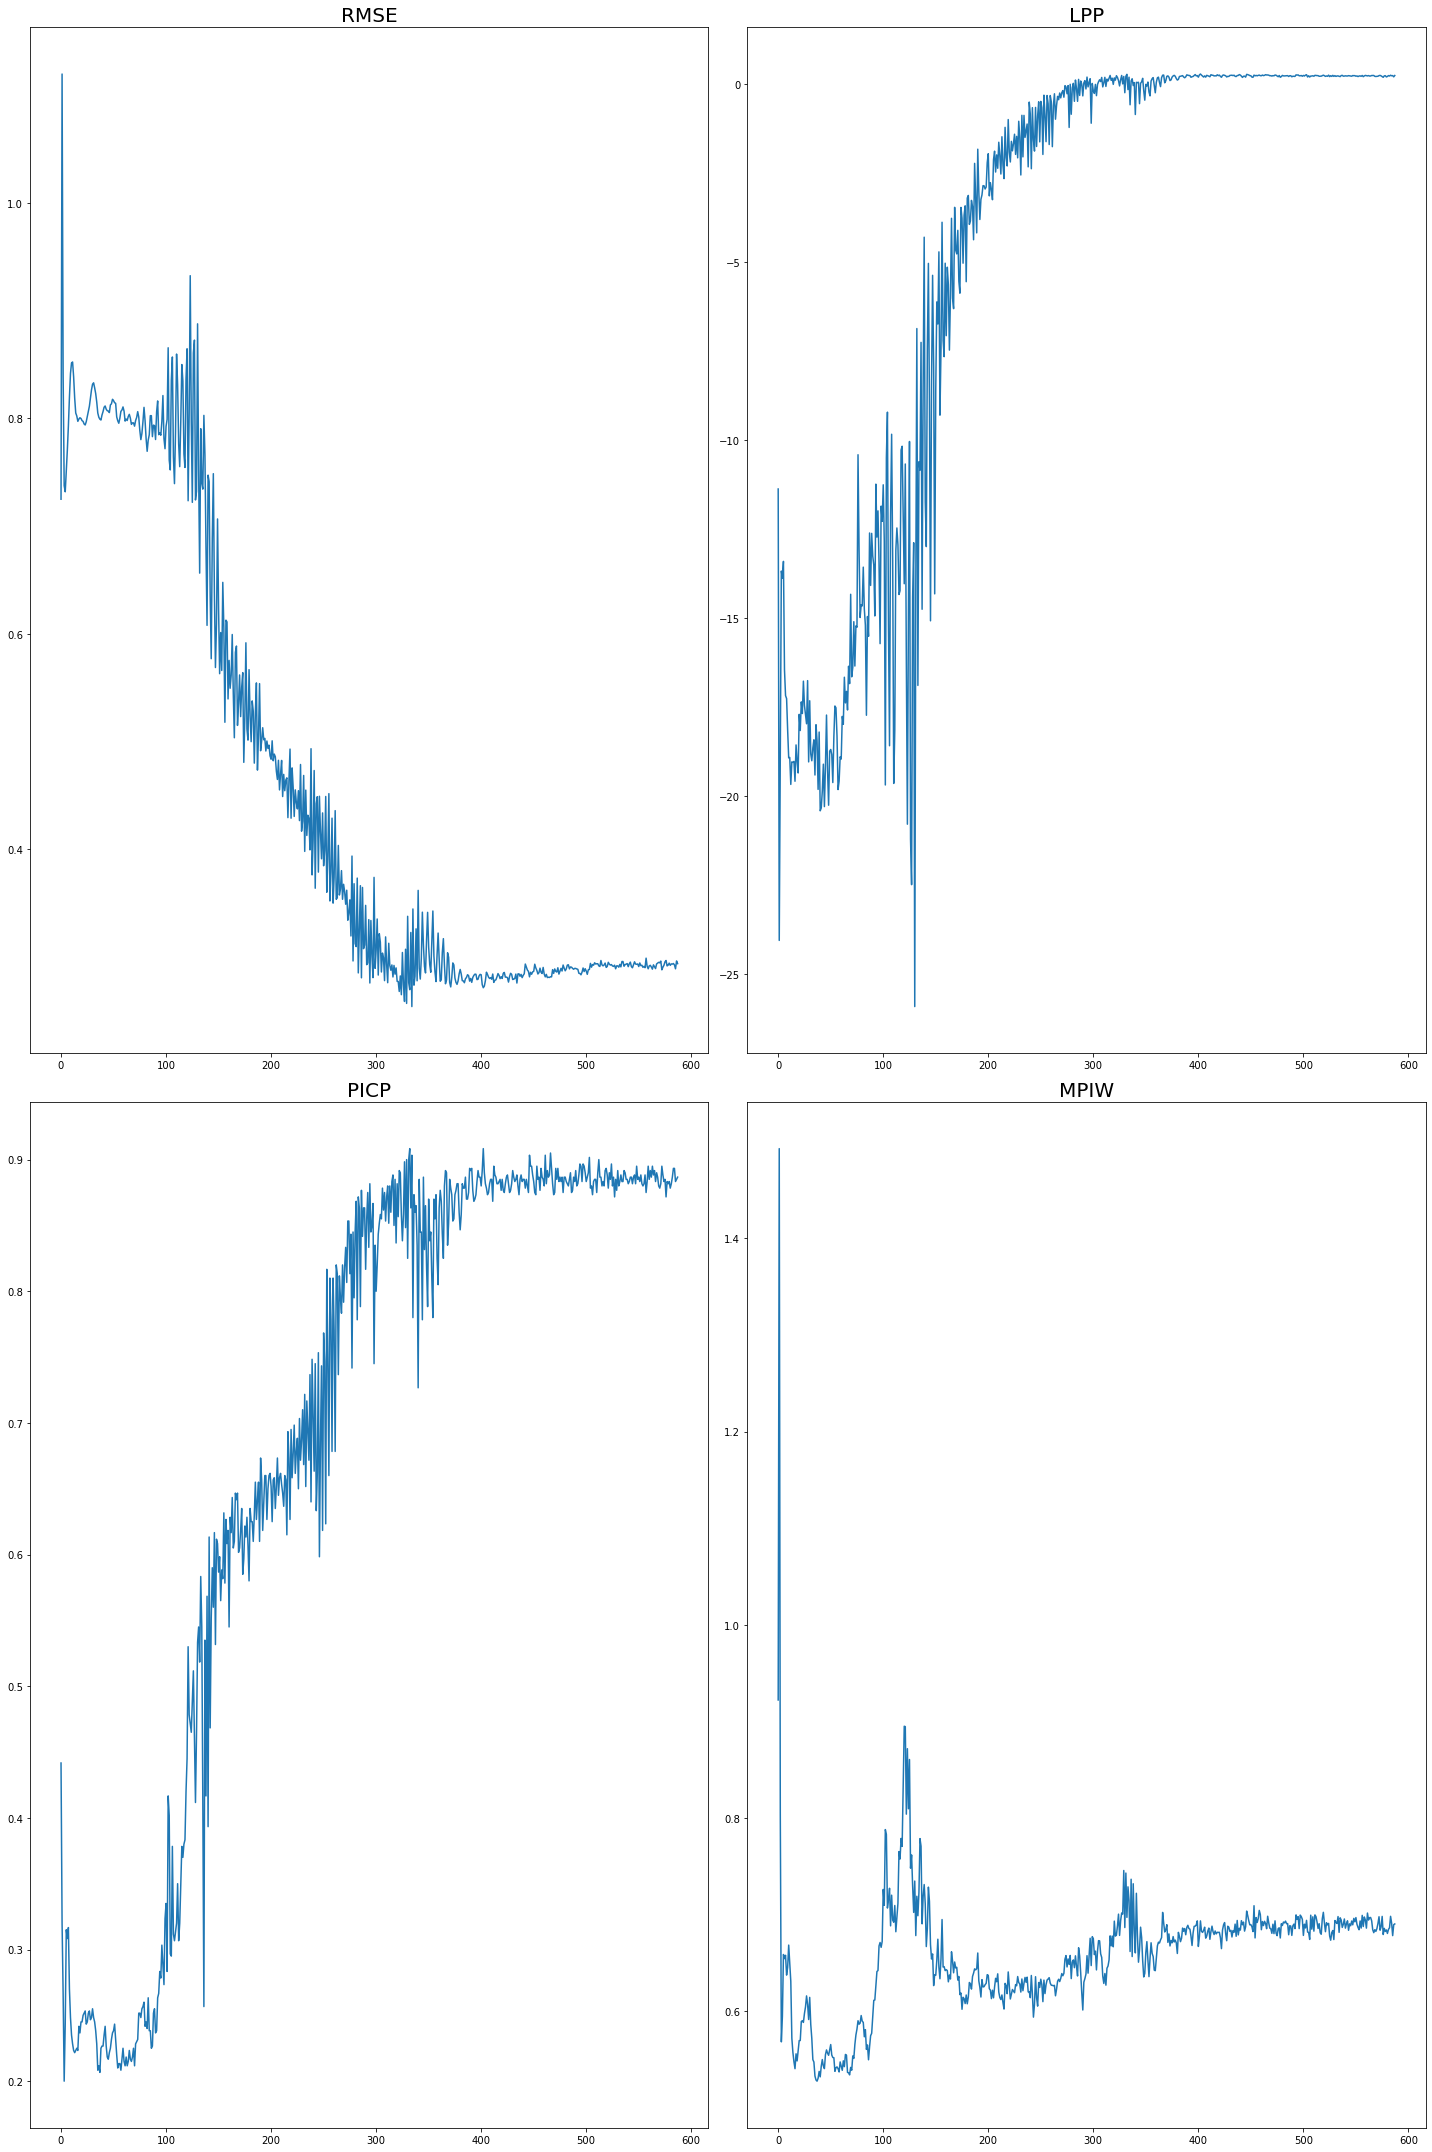

In [68]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(2,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
fig.tight_layout()

# Uncertainty vs error #

In [69]:
from torch.distributions import Uniform

sigma_noise_data = torch.tensor(0.1)
N = 25
M=100

X_l=Uniform(torch.tensor([-1.0]), torch.tensor([-.5])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r=Uniform(torch.tensor([.5]), torch.tensor([1.0])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_in=torch.cat([X_l,X_r]).to(device)
X_middle=Uniform(torch.tensor([-.5]), torch.tensor([.5])).sample(sample_shape=torch.Size([int(200)])).squeeze().to(device)
X_l_=Uniform(torch.tensor([-2.0]), torch.tensor([-1.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r_=Uniform(torch.tensor([1.]), torch.tensor([2.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_out=torch.cat([X_l_,X_r_]).to(device)
X_total=Uniform(torch.tensor([-2.0]), torch.tensor([-1.])).sample(sample_shape=torch.Size([int(1000)])).squeeze()
def f(X):
    y_ = torch.cos(4.0*(X+0.2)) 
    return y_ + sigma_noise_data* torch.randn_like(y_)

y_in=f(X_in).unsqueeze(-1)
y_middle=f(X_middle).unsqueeze(-1)
y_out=f(X_out).unsqueeze(-1)
y_total=f(X_total)
print(X_in.shape, y_in.shape)


torch.Size([200]) torch.Size([200, 1])


In [437]:
import seaborn as sns
X=[X_total]#[X_in,X_middle,X_out]
y=[y_total]#[y_in,y_middle,y_out]
label=['out of distribution']#['in distribution', 'in between', 'out of distribution']

def Entropy_(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x N X D
        k (Int): ordinal number

    Returns:
        (Tensor) H of size B, with H[b] k-Nearest Neighbour Estimation of the entropy of theta[b,:,:]

    """
    nb_samples=theta.shape[-2]
    dim=theta.shape[-1]
    kMC=torch.tensor(float(k_MC))
    D=torch.cdist(theta,theta)
    print(D.shape)
    a = torch.topk(D, k=k+1, dim=-1, largest=False, sorted=True)[0][:,:,-1]
    print('a: {}'.format(a.shape))
    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)#-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*a.div(torch.sqrt(kMC)).log().sum(-1)


Hs=[]
AEs=[]
for i in range(len(X)):
    theta=GeN(1000).detach()
    pred_=model(X[i],theta.cpu())
    pred=pred_+sigma_noise.cpu()*torch.randn(pred_.shape[0],1,1)

    print(X[i].shape)
    M = pred.shape[0]
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred_.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))

    print(pred.shape)
    H=(Entropy_(pred.transpose(0,1),k=20))
    print(H.shape)
    Hs.append(H)
    
    STD=(pred.std(0).squeeze())
    pred=model(X[i],theta.cpu())
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    L1error=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze()).abs())
    print(MSE.shape)
    AEs.append(L1error)
    ax=sns.scatterplot(H.cpu().numpy(),MSE.cpu().numpy(), label=label[i])
    
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')



RuntimeError: The size of tensor a (1000) must match the size of tensor b (500) at non-singleton dimension 1

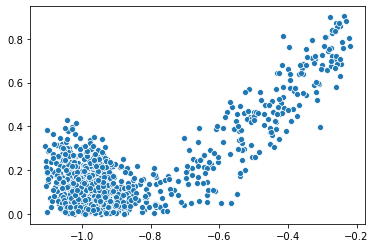

In [29]:
H_=torch.cat(Hs)
AE_=torch.cat(AEs)
sns.scatterplot(H_.cpu(),AE_.cpu())

In [29]:
#average log likelihood loss
from Tools import log_norm
def nll(x_data, y_data, theta):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """
    output=model(x_data,theta)
    y_pred=output[:-1,:,:]
    sigma_noise=torch.log(1. + torch.exp(output[-1,:,:])) + 1e-6
    log_proba=log_norm(y_data.unsqueeze(1), y_pred, sigma_noise.unsqueeze(0))
    return -log_proba.mean()

In [57]:
theta=torch.randn((11,param_count), device=device).requires_grad_(True)
#log_sigma=torch.tensor(0., device=device).requires_grad_(True)
params=[theta]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.1)
theta

tensor([[ 1.0427,  0.2547, -1.1250,  ...,  0.7009, -1.6748,  1.6438],
        [ 0.0326, -0.1381,  1.8362,  ...,  1.1169, -0.0921,  0.2630],
        [ 0.2847,  0.1339,  0.2234,  ..., -1.3767, -1.3539,  0.5811],
        ...,
        [ 1.2614, -0.6438, -0.1626,  ...,  0.7952, -0.9797, -1.3041],
        [ 0.1265, -1.4187,  0.8976,  ...,  1.0038, -0.5583, -0.4827],
        [ 1.1924,  0.8936, -0.1741,  ...,  0.2412,  0.4528,  2.2132]],
       device='cuda:0', requires_grad=True)

In [58]:
KLs=[]
ELBOs=[]
LLs=[]
LRs=[]


n_epochs=10000


start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        optimizer.zero_grad()

        
        scores={'LL':0.
        }
        example_count=0.
        

        with torch.enable_grad():
            for (x,y) in train_loader:
                optimizer.zero_grad()

                L=nll(x,y,theta)
                
                                
                L.backward()
                
                optimizer.step()

                tr.set_postfix(NegLogLike=L.item())

                


100%|██████████| 10000/10000 [00:33<00:00, 298.81it/s, NegLogLike=-.676]  


In [48]:
print(theta.shape)

torch.Size([11, 151])


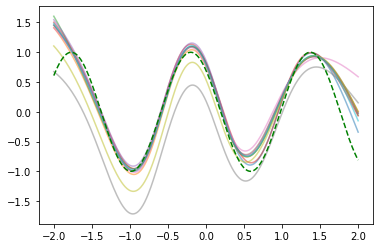

In [61]:


inputs=torch.linspace(-2.,2.,500).unsqueeze(-1).to(device)
f=model(inputs,theta).squeeze().detach().cpu()

for i in range(10):
    plt.plot(inputs.cpu(),f[i,:],alpha=0.5)
plt.plot(inputs.cpu(), torch.cos(4.0*(inputs+0.2)).cpu(),'--',color='green')


torch.Size([500])
torch.Size([500])
torch.Size([500, 1])


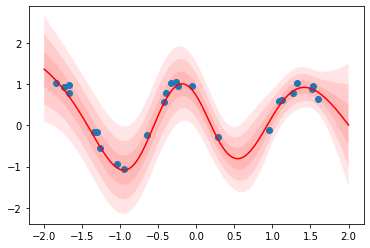

In [59]:
x_pred=inputs#torch.arange(-2.,2.,0.01).to(device)

output=model(x_pred,theta).detach()
f=output[:-1,:,:]
sigma_noise=sigma2 = torch.log(1. + torch.exp(output[-1,:])) + 1e-6
mean=f.mean(0).squeeze().cpu()
std=(f.std(0)+sigma_noise.detach()).squeeze().cpu()

print(std.shape)
print(mean.shape)
print(inputs.shape)


plt.plot(inputs.cpu(), mean, color='red')
for i in range(3):
    plt.fill_between(inputs.squeeze().cpu(), mean-(i+1)*std, mean+(i+1)*std, facecolor='red', alpha=0.1)
plt.scatter(x_train.cpu(),y_train.cpu())


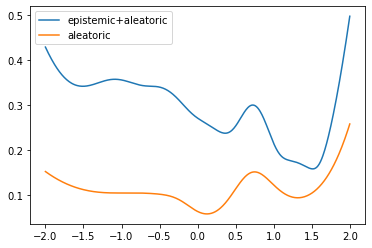

In [60]:
plt.plot(inputs.cpu(), std.cpu(), label='epistemic+aleatoric')
plt.plot(inputs.cpu(),sigma_noise.detach().cpu(),label='aleatoric')
plt.legend()